## Processing: 4861STDY7387182
### Vic-Fabienne 12/01/2022

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.2 pandas==1.3.4 scikit-learn==1.0.1 statsmodels==0.13.0 python-igraph==0.9.8 pynndescent==0.5.5


In [3]:
project_dir = '/home/vfs/PycharmProjects/Organoids_sc_WS2122'
# project_dir = '../../Organoids_sc_WS2122'
results_file = os.path.join(project_dir, 'results/Tissue_4861STDY7387182.h5ad')  # the file that will store the analysis results

In [4]:
adata = sc.read_10x_mtx(
    os.path.join(project_dir, 'data/Garcia_Alonso_tissue/'),  # the directory with the `.mtx` file
    prefix='4861STDY7387182_',
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading
# be aware that the feature file is a synthetic construct - see "merging_garcia_alonso_features.rmd"

... writing an h5ad cache file to speedup reading next time


Note: All files are undergoing some manual adjustment. The '_feature.tsv' files are added up to contain two columns
both (gene symbol) and from the '_cells.tsv' the header line is deleted.

In [5]:
adata.var_names_make_unique()

In [6]:
adata

AnnData object with n_obs × n_vars = 6356 × 28614
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


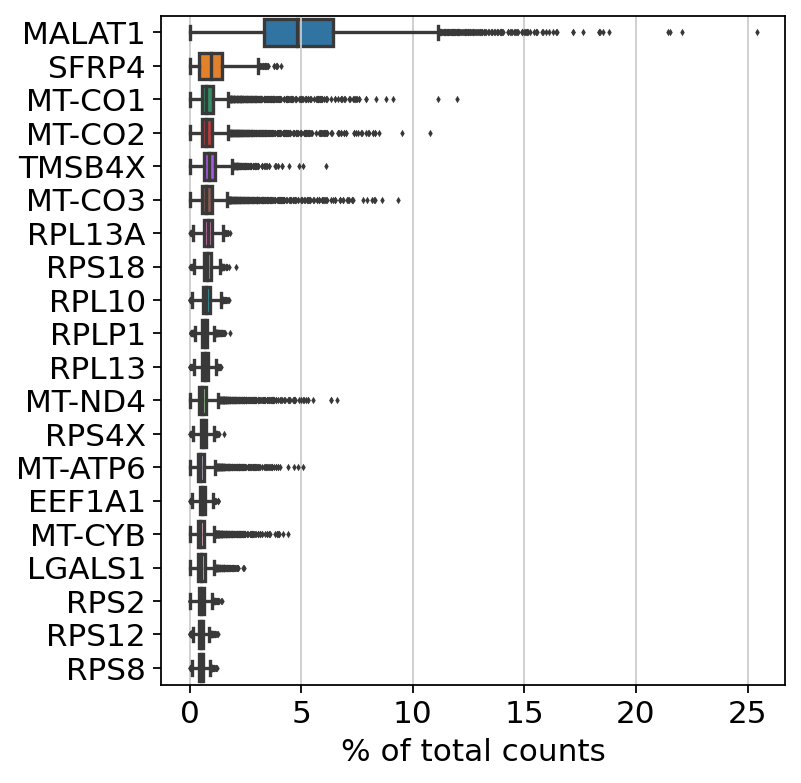

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 7120 genes that are detected in less than 3 cells


Let’s assemble some information about mitochondrial genes, which are important for quality control.
With pp.calculate_qc_metrics, we can compute many metrics very efficiently.

In [9]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

A violin plot of some of the computed quality measures:

the number of genes expressed in the count matrix
the total counts per cell
the percentage of counts in mitochondrial genes

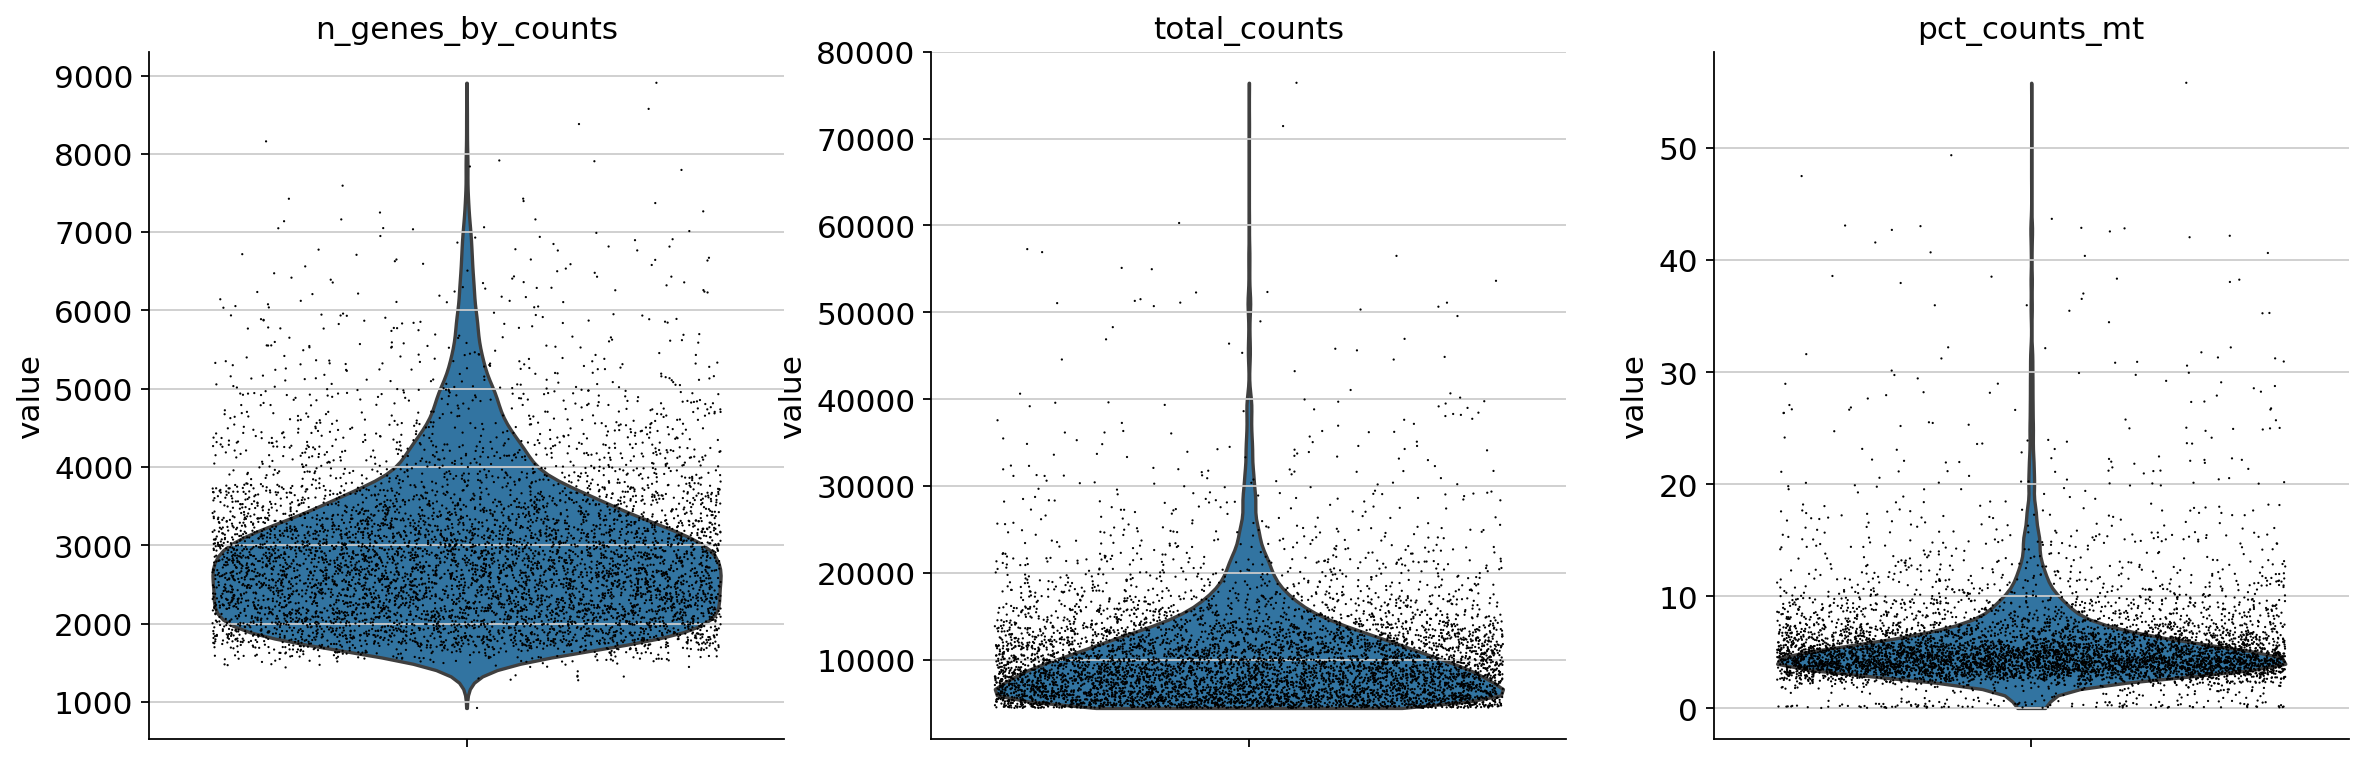

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts:

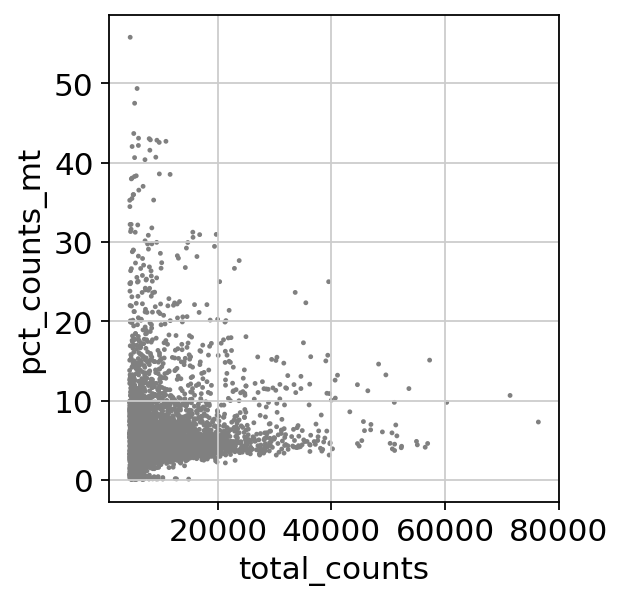

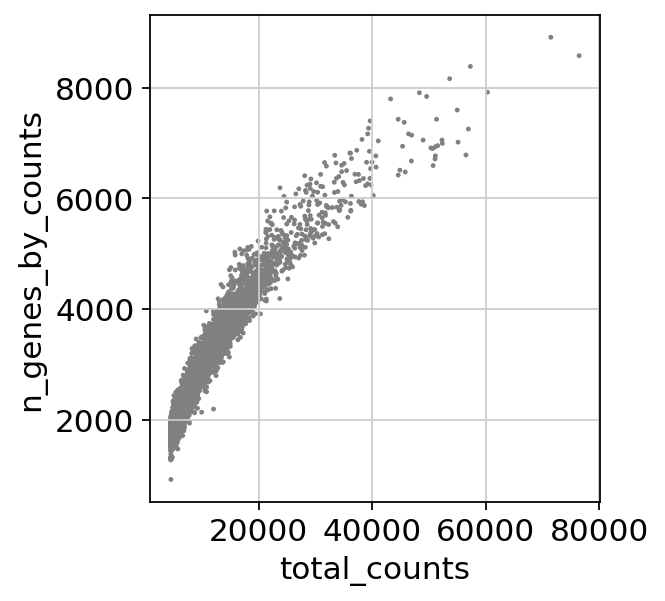

In [11]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Actually do the filtering by slicing the AnnData object.

In [41]:
adata = adata[adata.obs.n_genes_by_counts < 5500, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]

Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells.

In [46]:
sc.pp.normalize_total(adata, target_sum=3e4)

normalizing counts per cell
    finished (0:00:00)


/home/vfs/PycharmProjects/Organoids_sc_WS2122/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Logarithmize the data:

In [47]:
sc.pp.log1p(adata)

Identify highly-variable genes.

In [48]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


extracting highly variable genes


ValueError: Bin edges must be unique: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan]).
You can drop duplicate edges by setting the 'duplicates' kwarg

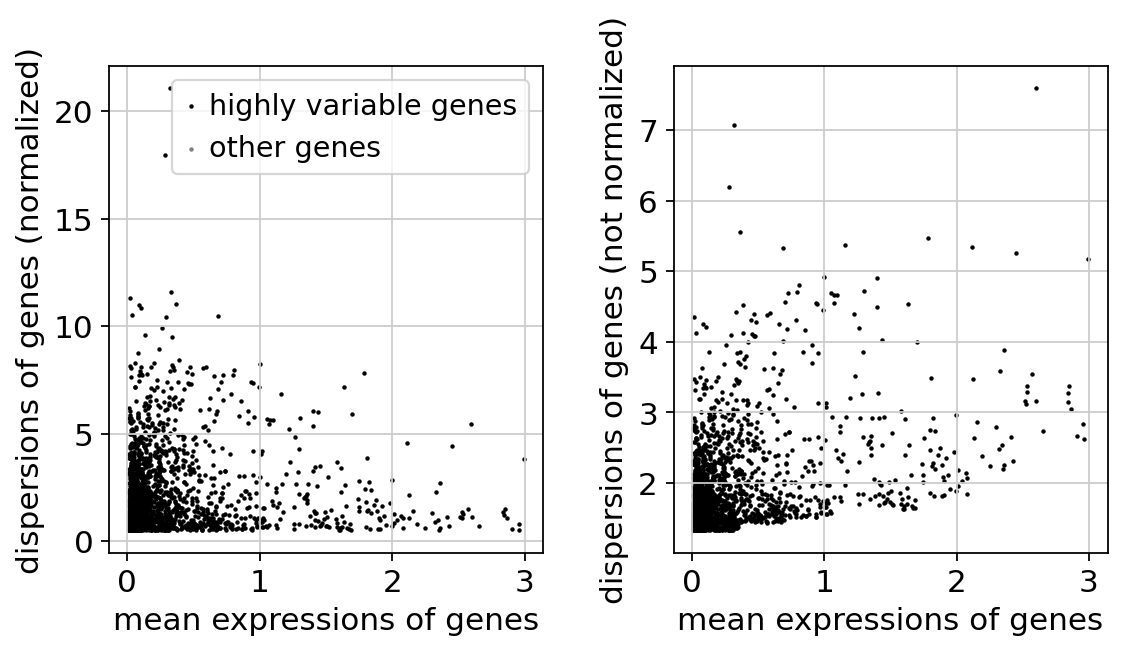

In [45]:
sc.pl.highly_variable_genes(adata)

Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

In [17]:
adata.raw = adata

Actually do the filtering

In [18]:
adata = adata[:, adata.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [19]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:09)


Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [20]:
sc.pp.scale(adata, max_value=10)

Principal component analysis
Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [21]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


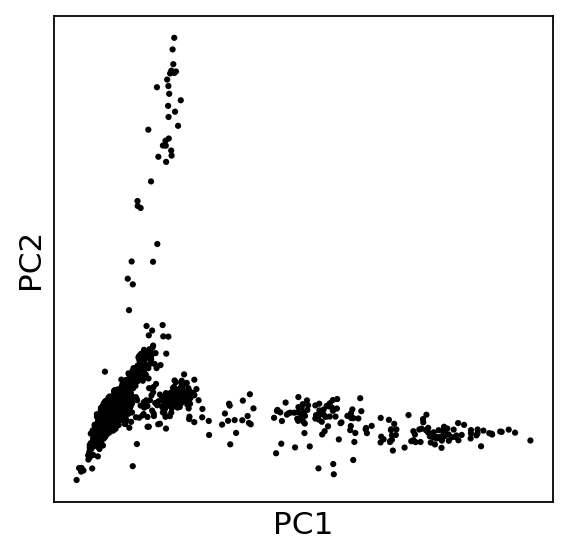

In [22]:
sc.pl.pca(adata, na_color='black')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine.

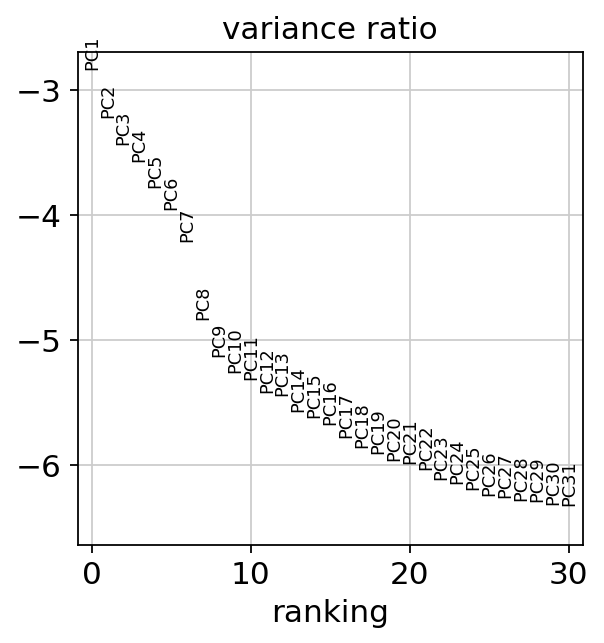

In [23]:
sc.pl.pca_variance_ratio(adata, log=True)

In [24]:
adata.write(results_file)

In [25]:
adata

AnnData object with n_obs × n_vars = 3843 × 2095
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

Computing the neighborhood graph
Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat’s results, let’s take the following values.

In [26]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


Embedding the neighborhood graph
We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

In [27]:
sc.tl.leiden(adata)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


In [28]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


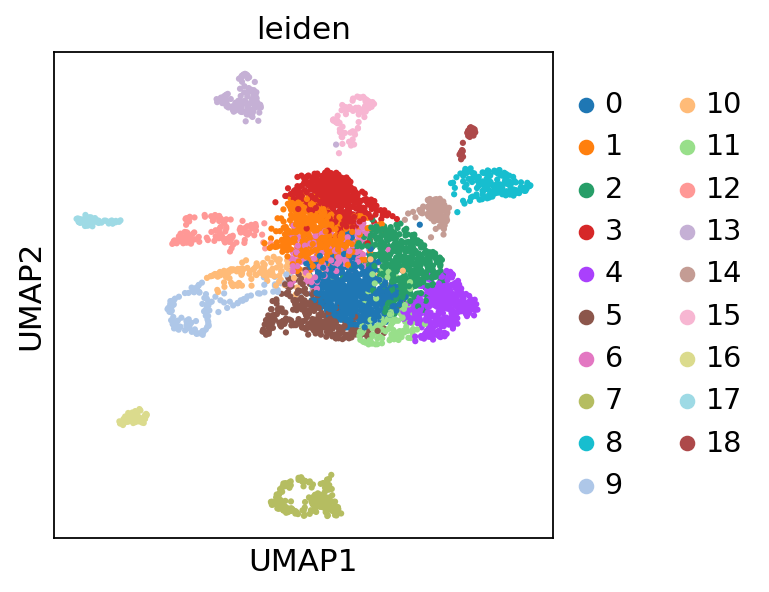

In [29]:
sc.pl.umap(adata, color = ["leiden"])

As we set the .raw attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to use .raw.

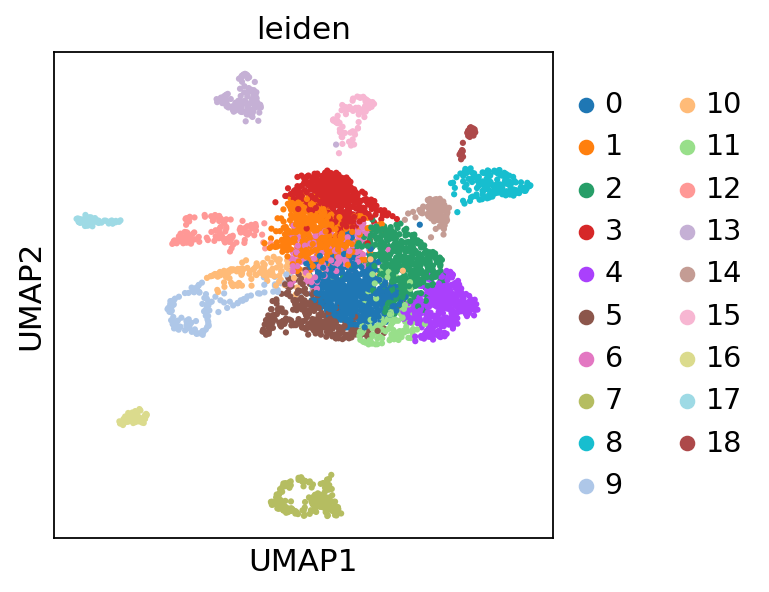

In [30]:
sc.pl.umap(adata, color=['leiden'], use_raw=False)

In [31]:
adata.write(results_file)

Finding marker genes
Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


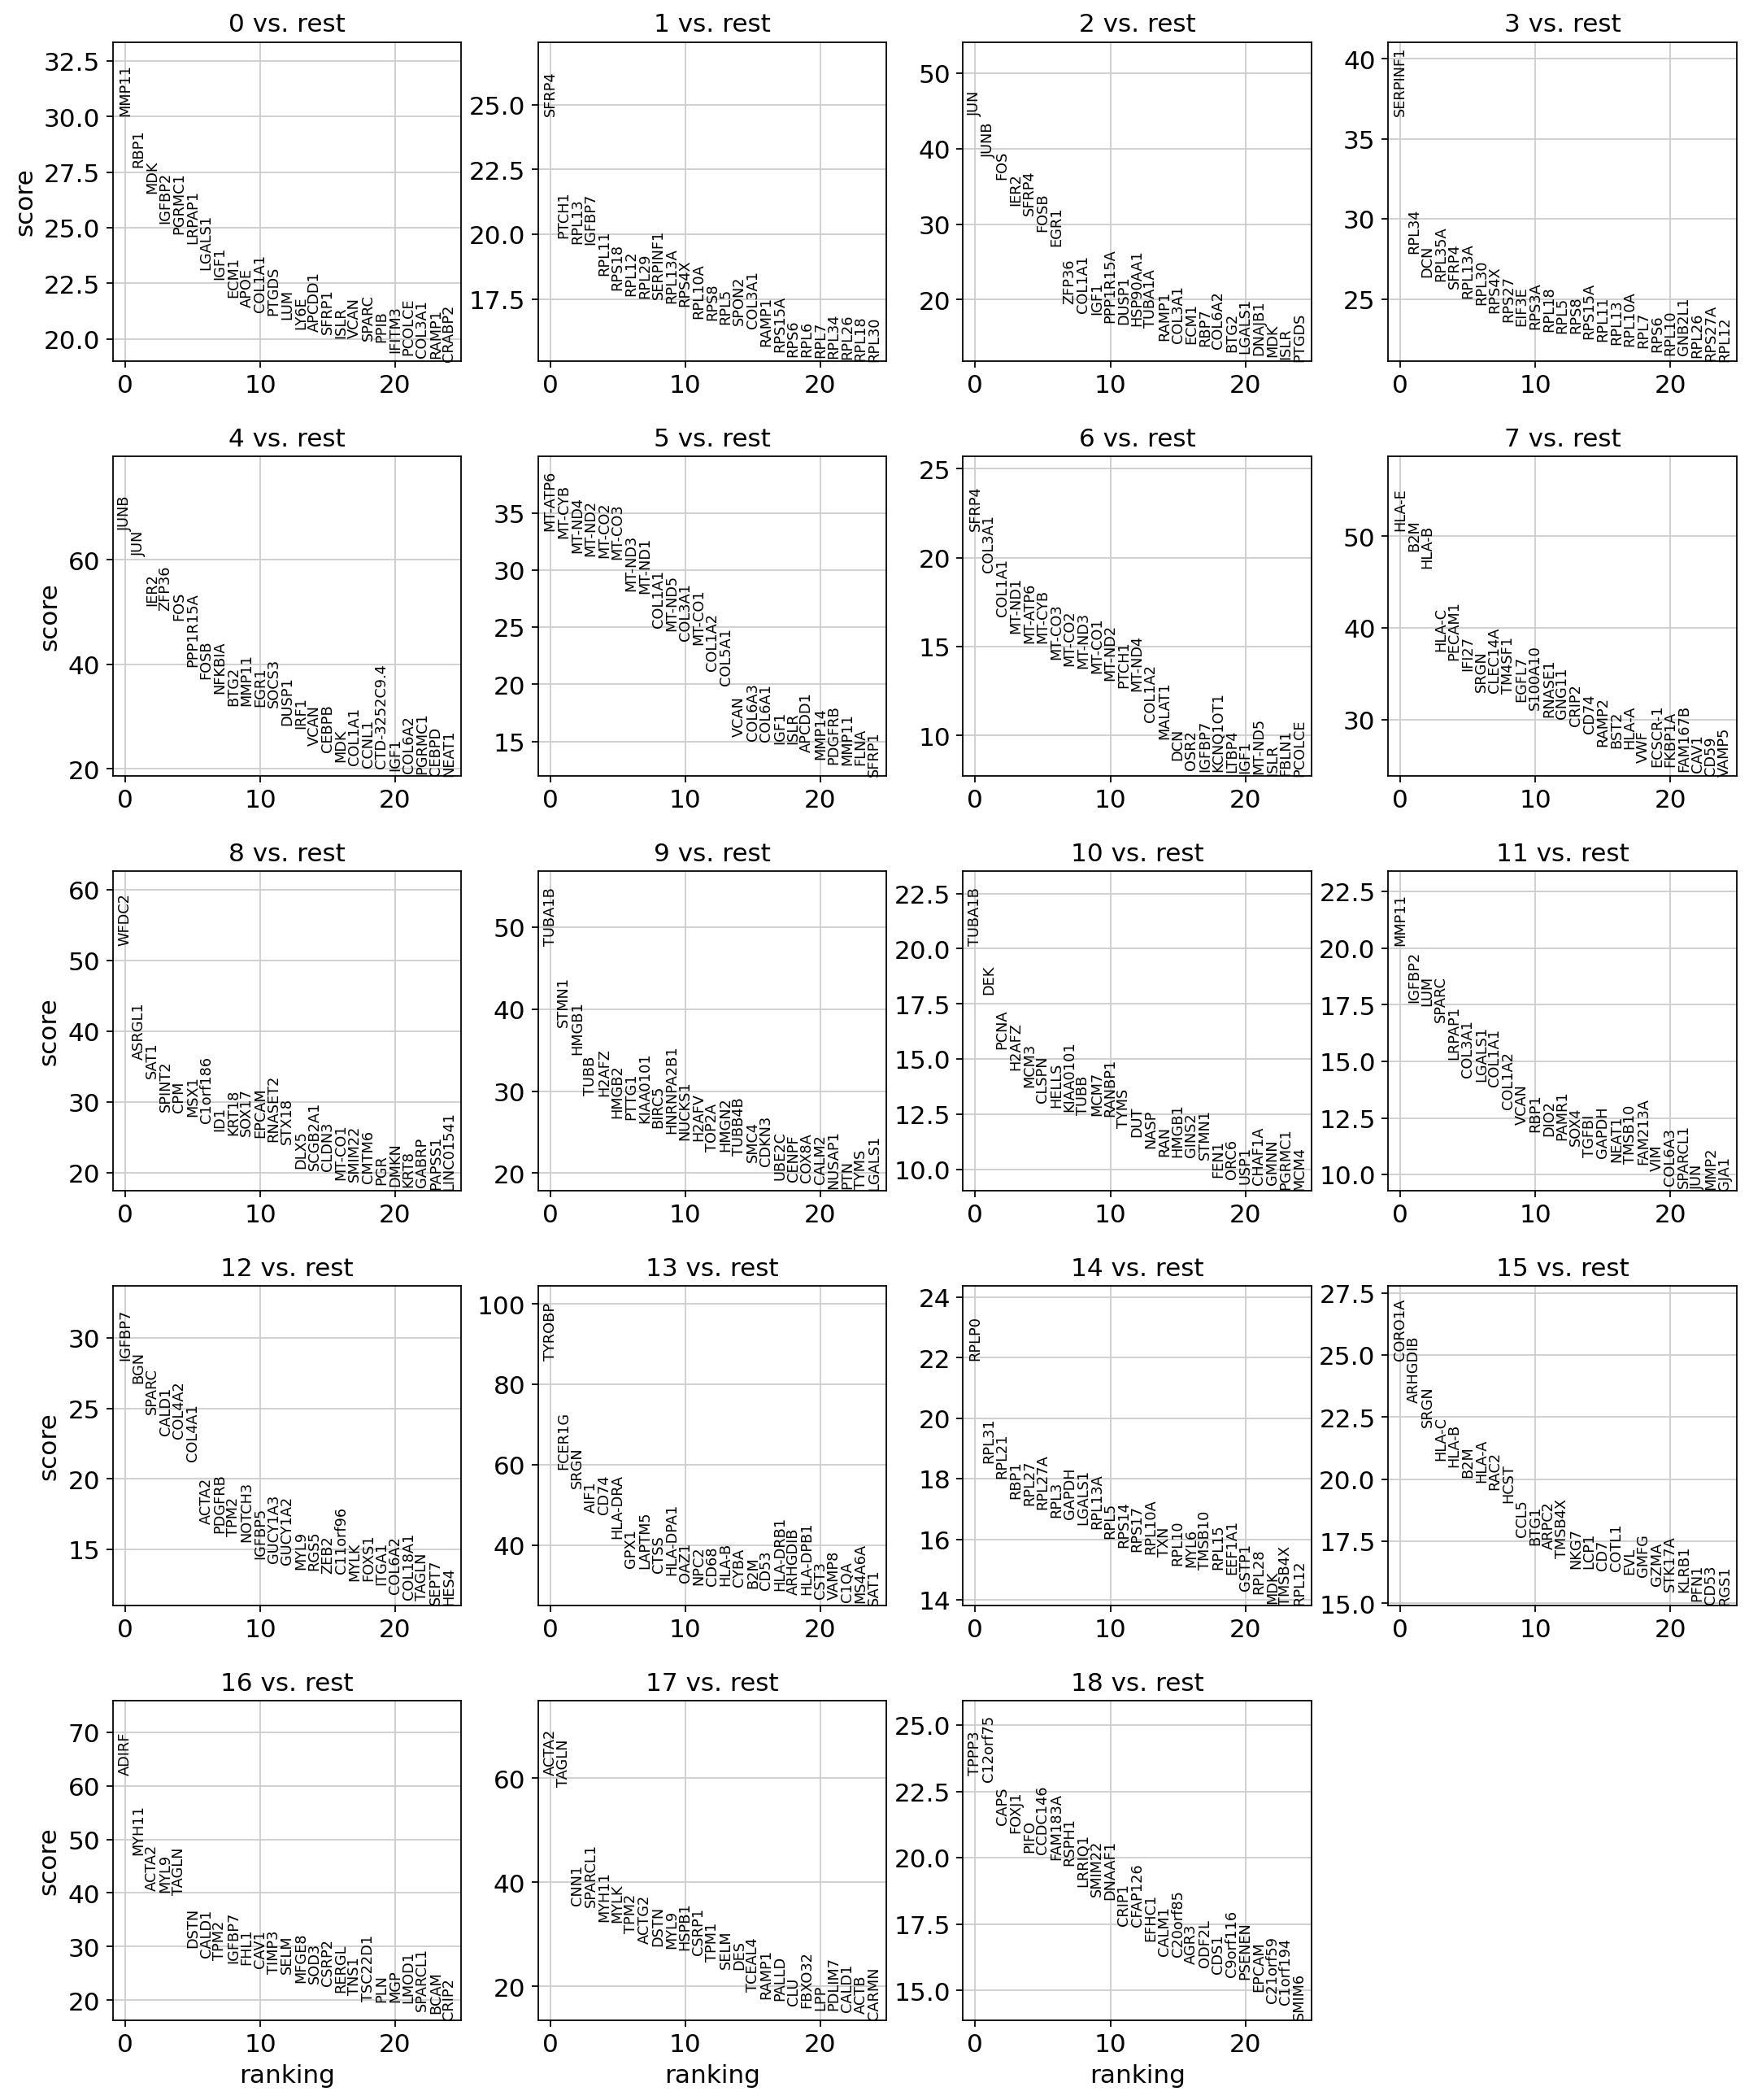

In [32]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [33]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a Wilcoxon rank-sum (Mann-Whitney-U) test is very similar. We recommend using the latter in publications, see e.g., Sonison & Robinson (2018). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:00:06)


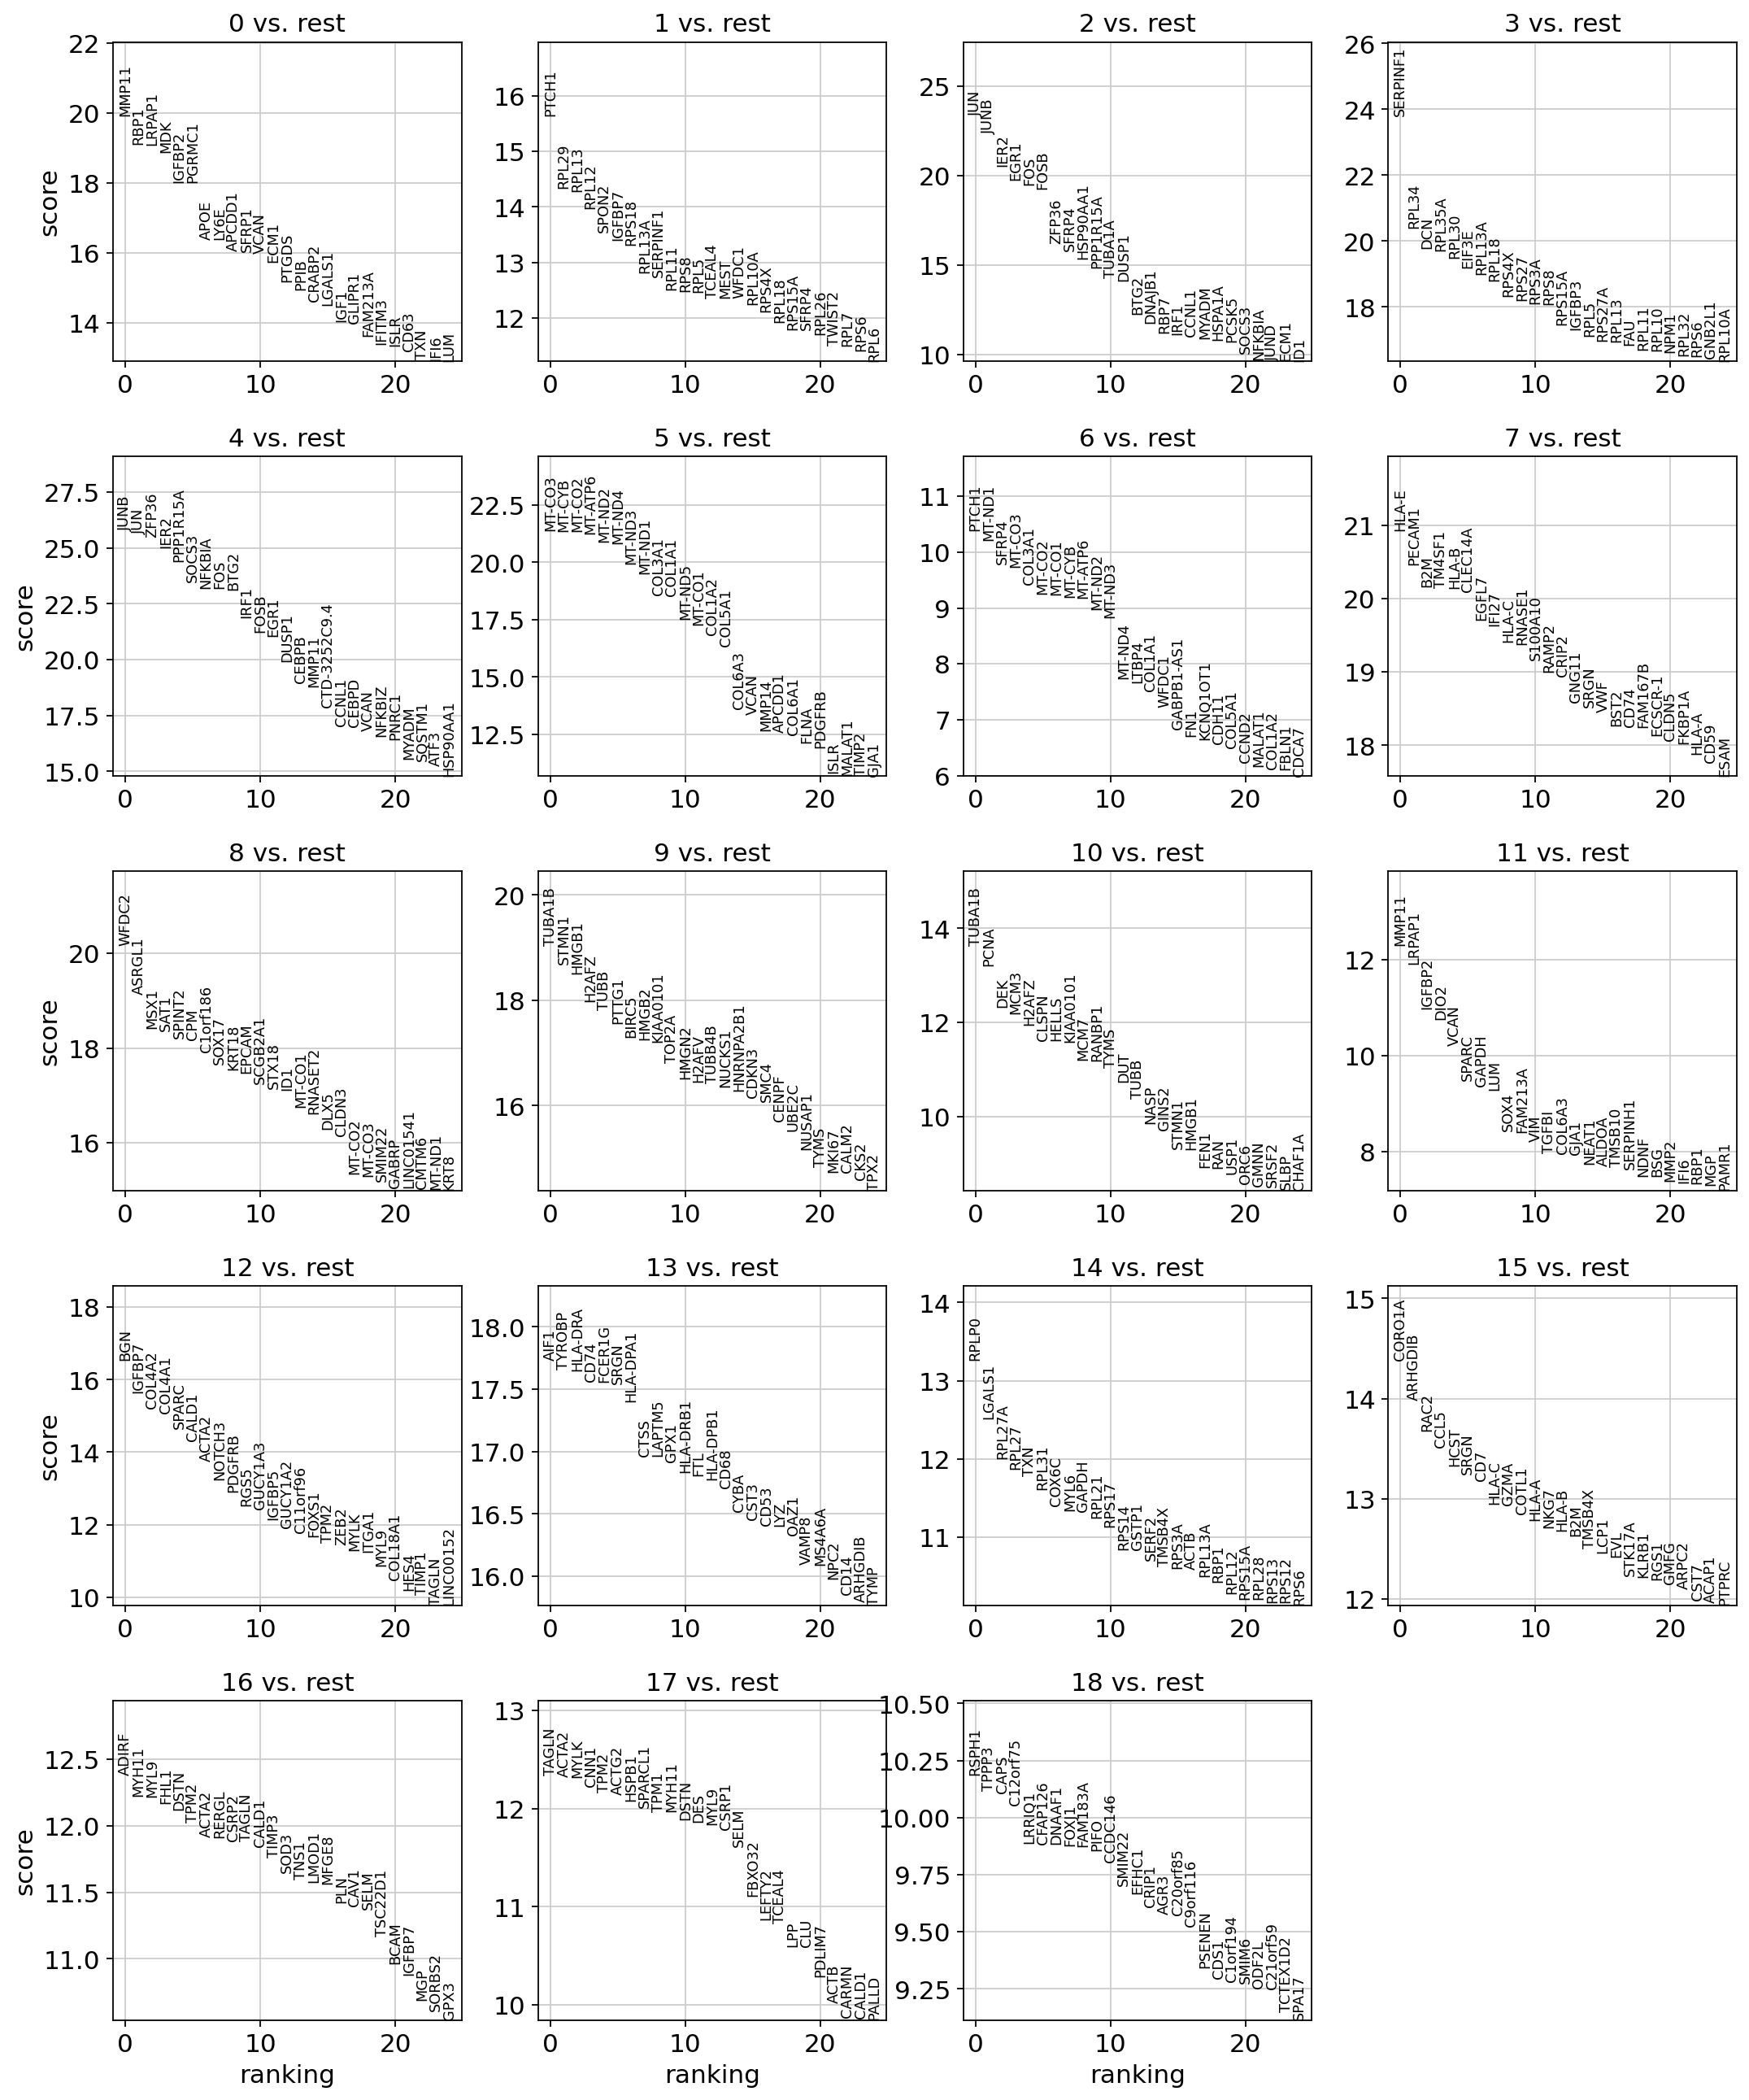

In [34]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [35]:
adata.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by Natranos et al. (2018). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. Clark et al. (2014) has more details.

ranking genes
    finished (0:00:31)


/home/vfs/PycharmProjects/Organoids_sc_WS2122/scanpy/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


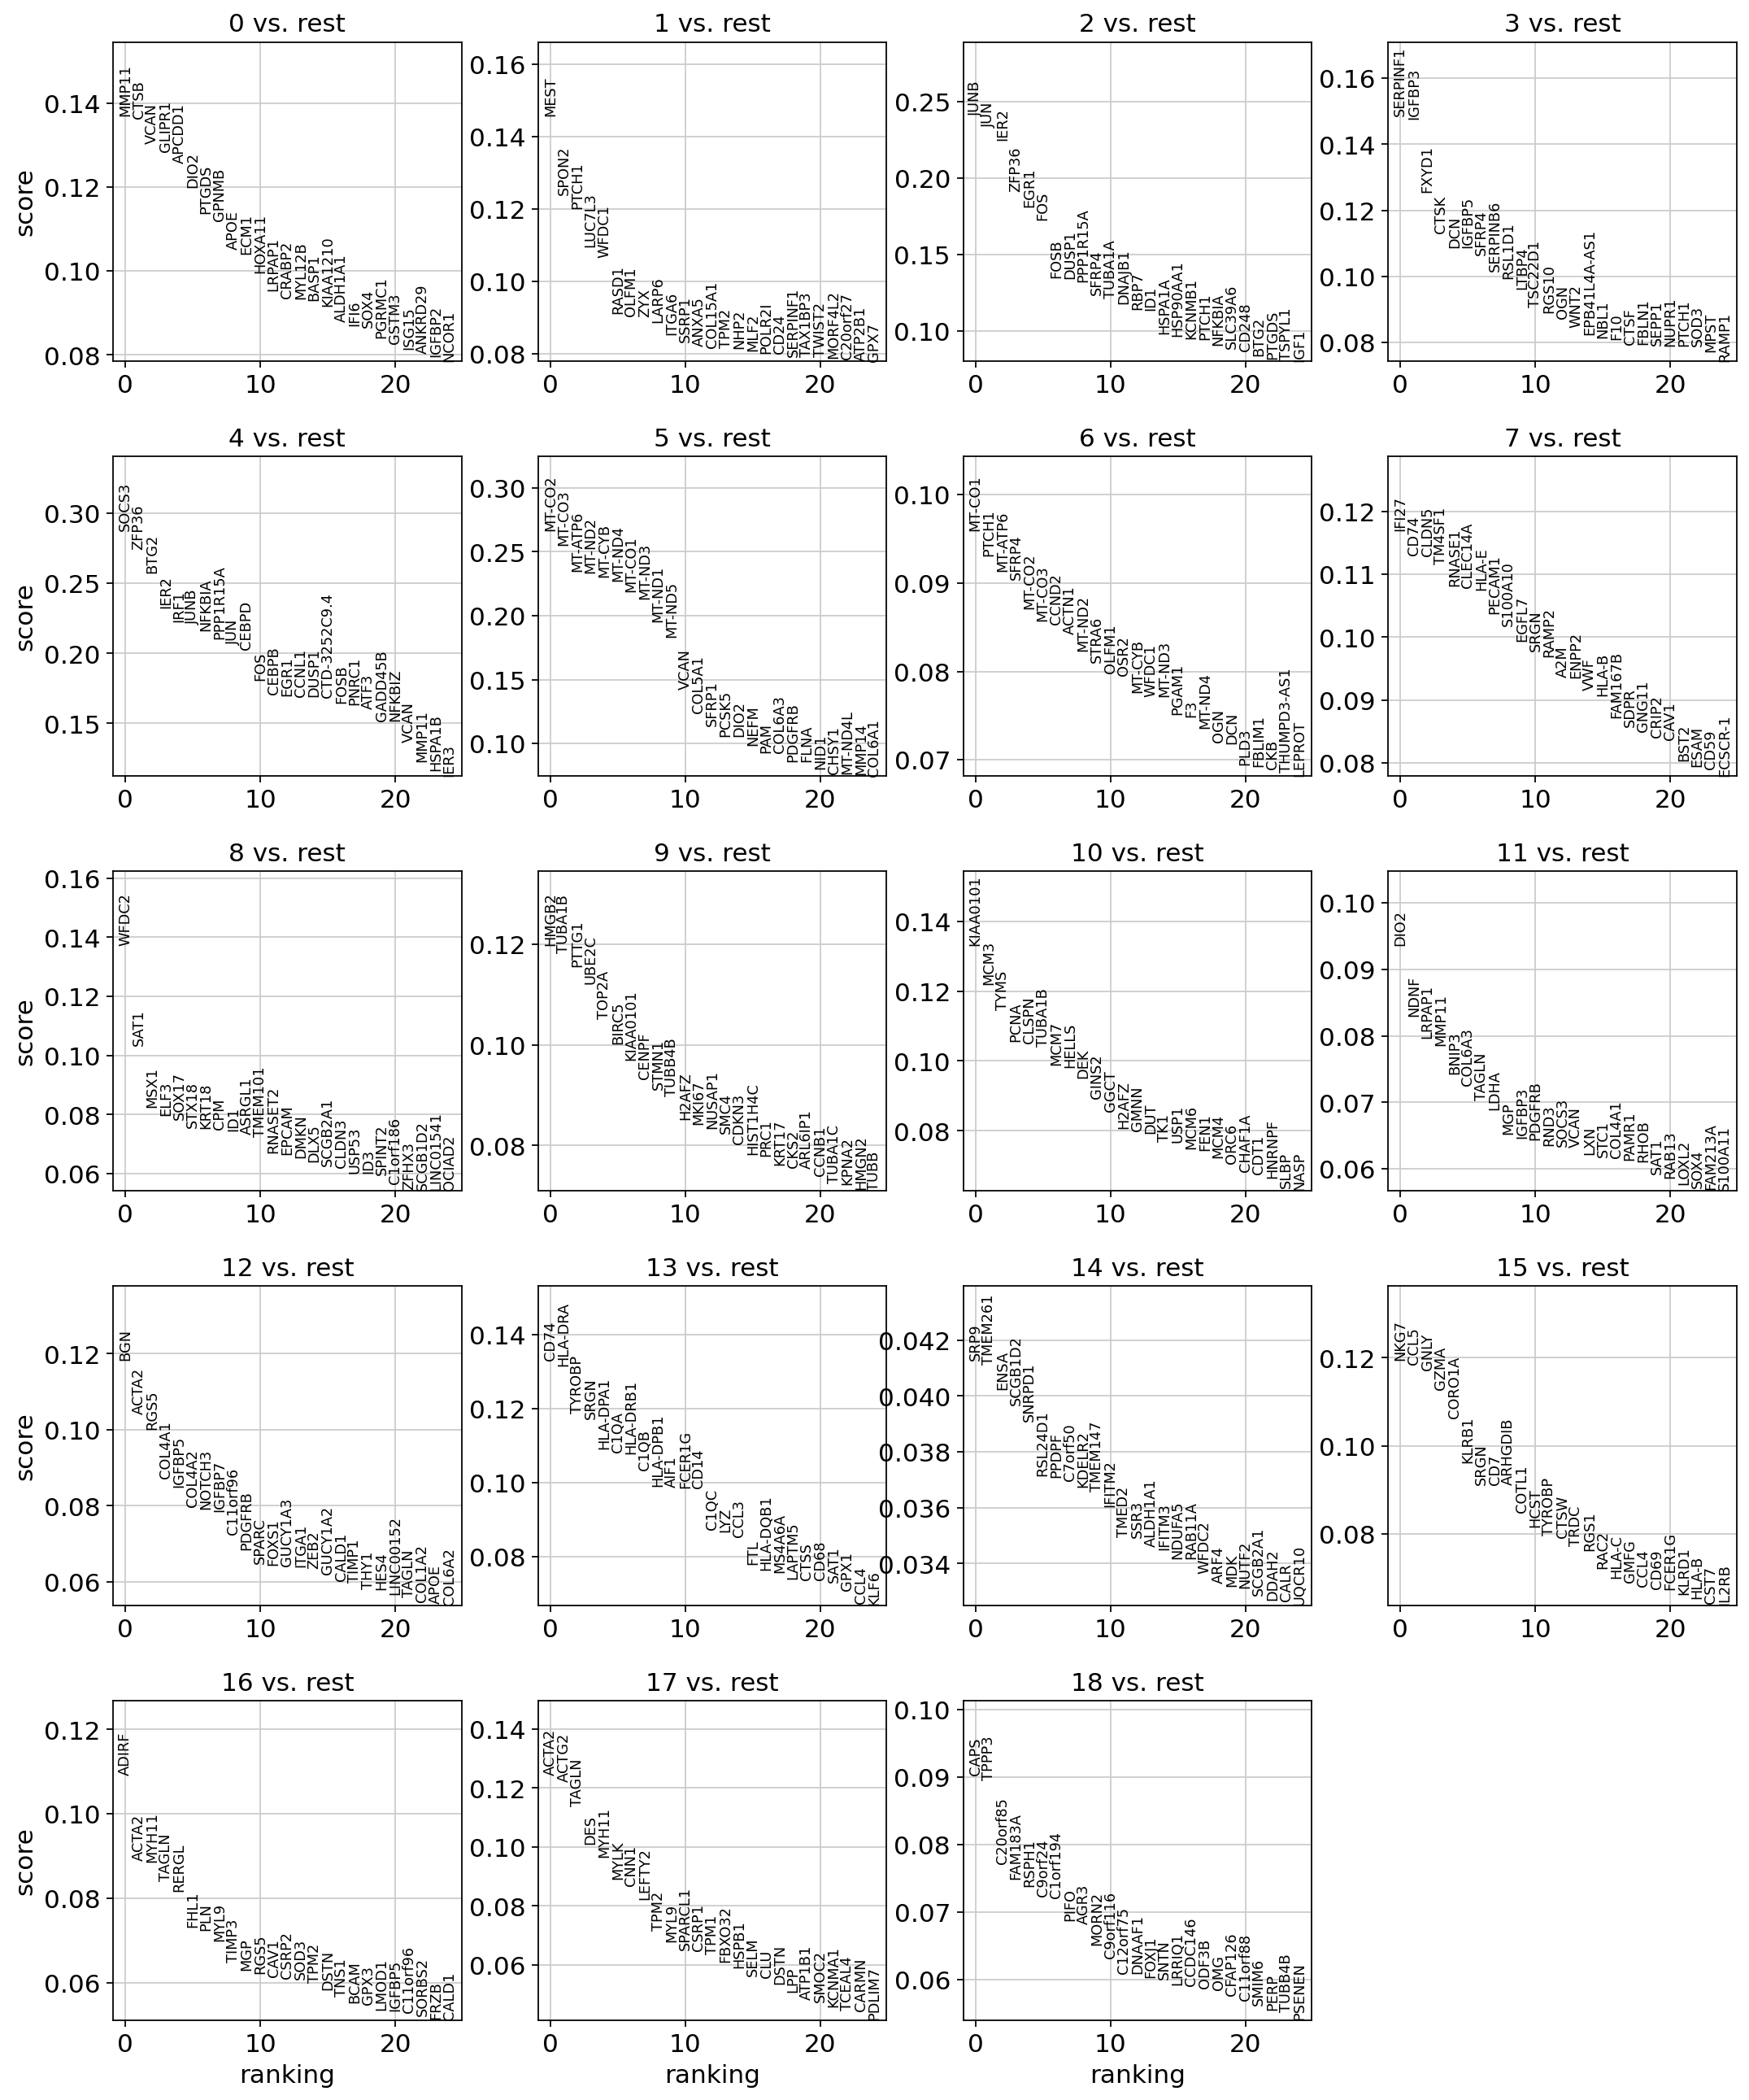

In [36]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [37]:
adata = sc.read(results_file)

In [38]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0      1     2         3         4        5       6       7       8  \
0   MMP11  PTCH1   JUN  SERPINF1      JUNB   MT-CO3   PTCH1   HLA-E   WFDC2   
1    RBP1  RPL29  JUNB     RPL34       JUN   MT-CYB  MT-ND1  PECAM1  ASRGL1   
2  LRPAP1  RPL13  IER2       DCN     ZFP36   MT-CO2   SFRP4     B2M    MSX1   
3     MDK  RPL12  EGR1    RPL35A      IER2  MT-ATP6  MT-CO3  TM4SF1    SAT1   
4  IGFBP2  SPON2   FOS     RPL30  PPP1R15A   MT-ND2  COL3A1   HLA-B  SPINT2   

        9      10      11      12       13      14       15     16     17  \
0  TUBA1B  TUBA1B   MMP11     BGN     AIF1   RPLP0   CORO1A  ADIRF  TAGLN   
1   STMN1    PCNA  LRPAP1  IGFBP7   TYROBP  LGALS1  ARHGDIB  MYH11  ACTA2   
2   HMGB1     DEK  IGFBP2  COL4A2  HLA-DRA  RPL27A     RAC2   MYL9   MYLK   
3   H2AFZ    MCM3    DIO2  COL4A1     CD74   RPL27     CCL5   FHL1   CNN1   
4    TUBB   H2AFZ    VCAN   SPARC   FCER1G     TXN     HCST   DSTN   TPM2   

         18  
0     RSPH1  
1     TPPP3  
2      CAPS  
3  C12orf75  
4    LRRIQ1

In [40]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

0_n           0_p       1_n           1_p       2_n            2_p  \
0   MMP11  2.304012e-88     PTCH1  3.481599e-55       JUN  1.163695e-120   
1    RBP1  1.657730e-81     RPL29  1.137042e-46      JUNB  1.451243e-110   
2  LRPAP1  3.850354e-81     RPL13  2.942200e-46      IER2   1.146432e-93   
3     MDK  1.571766e-79     RPL12  2.511094e-44      EGR1   9.174712e-87   
4  IGFBP2  1.341446e-72     SPON2  7.542549e-42       FOS   1.226178e-84   
5  PGRMC1  1.530235e-72    IGFBP7  6.304182e-41      FOSB   1.671507e-82   
6    APOE  2.421080e-60     RPS18  2.053255e-40     ZFP36   4.009278e-59   
7    LY6E  2.640934e-60    RPL13A  1.493548e-37     SFRP4   2.456851e-56   
8  APCDD1  5.301628e-58  SERPINF1  3.446553e-37  HSP90AA1   3.181199e-53   
9   SFRP1  6.409177e-58     RPL11  6.963248e-36  PPP1R15A   8.510527e-50   

        3_n            3_p       4_n            4_p  ...    14_n  \
0  SERPINF1  2.765955e-125      JUNB  1.072128e-146  ...   RPLP0   
1     RPL34   2.248575e-92       JUN  8.354087e-145  ...  LGALS1   
2       DCN   4.141000e-87     ZFP36  3.686579e-143  ...  RPL27A   
3    RPL35A   2.390193e-86      IER2  3.158699e-138  ...   RPL27   
4     RPL30   1.476578e-84  PPP1R15A  2.374018e-131  ...     TXN   
5     EIF3E   4.721092e-82     SOCS3  6.281678e-122  ...   RPL31   
6    RPL13A   2.399959e-80    NFKBIA  3.389291e-119  ...   COX6C   
7     RPL18   7.113581e-79       FOS  6.378773e-119  ...    MYL6   
8     RPS4X   6.738874e-75      BTG2  2.630823e-118  ...   GAPDH   
9     RPS27   6.096837e-74      IRF1  2.840249e-106  ...   RPL21   

           14_p     15_n          15_p   16_n          16_p     17_n  \
0  3.564816e-40   CORO1A  6.243606e-47  ADIRF  3.201918e-35    TAGLN   
1  6.332571e-36  ARHGDIB  1.805282e-44  MYH11  2.356981e-34    ACTA2   
2  3.432506e-33     RAC2  1.361717e-42   MYL9  2.608455e-34     MYLK   
3  1.654998e-32     CCL5  1.295682e-41   FHL1  4.611764e-34     CNN1   
4  4.697299e-32     HCST  1.568351e-40   DSTN  8.281126e-34     TPM2   
5  3.439299e-31     SRGN  4.614207e-40   TPM2  2.599949e-33    ACTG2   
6  4.320236e-30      CD7  1.088323e-39  ACTA2  9.453923e-33    HSPB1   
7  8.603433e-30    HLA-C  2.461156e-38  RERGL  1.008811e-32  SPARCL1   
8  9.456907e-30     GZMA  2.745609e-38  CSRP2  1.376323e-32     TPM1   
9  2.539877e-29    COTL1  9.095712e-38  TAGLN  1.397211e-32    MYH11   

           17_p      18_n          18_p  
0  5.090157e-35     RSPH1  2.229486e-24  
1  6.266060e-35     TPPP3  4.453410e-24  
2  6.892125e-35      CAPS  4.976081e-24  
3  2.267483e-34  C12orf75  8.692073e-24  
4  4.386388e-34    LRRIQ1  4.742498e-23  
5  5.855259e-34   CFAP126  4.815530e-23  
6  1.371216e-33    DNAAF1  4.841353e-23  
7  3.057728e-33     FOXJ1  5.245562e-23  
8  4.931081e-33   FAM183A  5.322195e-23  
9  4.938567e-33      PIFO  6.563797e-23  

[10 rows x 38 columns]